# Entendimiento de datos

**Conjunto de datos:** Dataset 2 - Lugares de emisiones

**Nombre de archivo:** emission_permits_anom_2.json

## 0. Inicialización

### 0.1. Perfilamiento de datos

Instalar ydata-profiling

In [2]:
!pip install ydata-profiling

Instalar folium

In [3]:
!pip install folium

Importaciones

In [4]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

import re
import json
import folium
from tabulate import tabulate

Visualización de tablas y gráficas

In [5]:
sns.set_style("darkgrid")

def print_table(df):
    print(tabulate(df, headers='keys', tablefmt='simple_outline'))

Lectura y muestra del archivo

In [6]:
# 1. Cargar el JSON
with open('../data/emission_permits_anom_2.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 2. Extraer features
features = data['features']

# 3. Construir DataFrame con properties y coordenadas
df = pd.DataFrame([
    {
        **feature['properties'],
        'Latitud': feature['geometry']['coordinates'][1],
        'Longitud': feature['geometry']['coordinates'][0]
    }
    for feature in features
])

df.head()

,IDExpediente,Estado,Regional,Departamento,Municipio,Vereda,Class,TipoCombustible,TipoFuenteEmision,Cuenca,Latitud,Longitud
0,73640.0,Seguimiento y Control,Sabana Occidente,Cundinamarca,MOSQUERA,CENTRO,None,Otros,Horno,Río Bogotá,4.703418,-74.226561
1,73788.0,Seguimiento y Control,Ubate,Cundinamarca,LENGUAZAQUE,Resguardo,None,Carbón,Caldera Horno,Río Suárez,5.318407,-73.704281
2,74314.0,Seguimiento y Control,Sabana Occidente,Cundinamarca,MADRID,LA PUNTA,None,ACPM,Caldera Horno,Río Bogotá,4.800462,-74.210355
3,75972.0,Seguimiento y Control,Sabana Occidente,Cundinamarca,MOSQUERA,Balsillas,None,Fuel Oil No.8,Planta de Asfalto,Río Bogotá,4.678797,-74.284112
4,78824.0,Seguimiento y Control,Sabana Occidente,Cundinamarca,FUNZA,El Hato,None,Carbón,Caldera Horno,Río Bogotá,4.699590,-74.193752


Guardar el dataset completo en archivo más accesible

In [7]:
df.to_csv('../data/emission_permits_anom_2.csv', index=False, encoding='utf-8')

**Hallazgos:** Cada fila representa una fuente fija de emisión perteneciente a una empresa en la región central (Cundinamarca y Boyacá), que cuenta con un permiso ambiental para la liberación de contaminantes atmosféricos.

Cada fuente cuenta con:

- Identificador del expediente o trámite del permiso de emisión de contaminantes aéreos
- Estado del trámite / licencia
- Región administrativa de la Corporación Autónoma 
Regional (CAR)
- Departamento, municipio y vereda donde se ubica la fuente
- Clase de infracción cometida
- Tipo de combustible usado por la fuente
- Tipo de fuente
- Cuenca hidrográfica asociada al área de influencia
- Localización geográfica (latitud y longitud) de la fuente

Información del archivo (Cantidad de filas, cantidad de columnas y tipos de dato)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDExpediente       544 non-null    float64
 1   Estado             544 non-null    object 
 2   Regional           544 non-null    object 
 3   Departamento       544 non-null    object 
 4   Municipio          544 non-null    object 
 5   Vereda             544 non-null    object 
 6   Class              321 non-null    object 
 7   TipoCombustible    544 non-null    object 
 8   TipoFuenteEmision  544 non-null    object 
 9   Cuenca             544 non-null    object 
 10  Latitud            544 non-null    float64
 11  Longitud           544 non-null    float64
dtypes: float64(3), object(9)
memory usage: 51.1+ KB


Columnas agrupadas por tipo de dato

In [9]:
columnas_por_tipo = df.columns.to_series().groupby(df.dtypes).groups

print("Columnas agrupadas por tipo de dato:\n")
for tipo, cols in columnas_por_tipo.items():
    print(f"{tipo} ({len(cols)} columnas): {', '.join(cols)}")

Columnas agrupadas por tipo de dato:

float64 (3 columnas): IDExpediente, Latitud, Longitud
object (9 columnas): Estado, Regional, Departamento, Municipio, Vereda, Class, TipoCombustible, TipoFuenteEmision, Cuenca


**Hallazgos:**
- Solamente por tipo de dato, hay 9 variables categóricas (object) y 3 variables numéricas (int64 y float64)
- 1 en realidad es variable categórica, por lo que tenemos:
    - **10 variables categóricas:** IDExpediente, Estado, Regional, Departamento, Municipio, Vereda, Class, TipoCombustible, TipoFuenteEmision, Cuenca
    - **2 variables numéricas:** Latitud, Longitud
- Hay tipos de dato que probablemente no corresponden a los valores posibles de las columnas, por lo que estos problemas deben ser abordados. Esto ocurre para la columna `IDExpediente`, por lo que se propone cambiarla a int

### 0.2. Cambios sobre las columnas

Verificamos si esta columna puede ser convertida a int

In [10]:
puede_int = (df['IDExpediente'].dropna() % 1 == 0).all()
print(f"'IDExpediente': {'se puede convertir a int' if puede_int else 'mantener como float'}")

'IDExpediente': se puede convertir a int


Como sí puede serlo, ejecutamos el cambio

In [11]:
df['IDExpediente'] = df['IDExpediente'].astype("Int64")

## 1. Variables categóricas

Temporalmente, mapeamos las variables categóricas guardadas como número a texto

In [12]:
cols_otra_categoria = ['IDExpediente']

for col in cols_otra_categoria:
    df[f"{col}_obj"] = df[col].astype("object")

Variables categóricas encontradas

In [13]:
non_numeric_attributes = df.select_dtypes(exclude=['number']).columns.values
pd.DataFrame(non_numeric_attributes, columns=['Non Numeric Attributes'])

,Non Numeric Attributes
0,Estado
1,Regional
2,Departamento
3,Municipio
4,Vereda
5,Class
6,TipoCombustible
7,TipoFuenteEmision
8,Cuenca
9,IDExpediente_obj


Conteo de filas, cantidad de filas únicas, moda y su frecuencia

In [14]:
with pd.option_context('display.max_colwidth', None):
    display(df[non_numeric_attributes].describe())

,Estado,Regional,Departamento,Municipio,Vereda,Class,TipoCombustible,TipoFuenteEmision,Cuenca,IDExpediente_obj
count,544,544,544,544,544,321,544,544,544,544
unique,3,14,3,65,148,3,12,30,7,502
top,Sancionatorio,Sabana Centro,Cundinamarca,SOACHA,MOCHUELO BAJO,Por emisiones atmosféricas sin cumplir con los requisitos de ley,(sin definir),(sin definir),Río Bogotá,183556
freq,321,130,461,58,47,142,329,328,317,6


**Hallazgos:**

- Hay 3 estados, y el más común es Sancionatorio
- Hay 14 regionales, y la más común es Sabana Centro
- Hay 3 valores únicos en la columna `Departamento`, y el más común es Cundinamarca
- Hay 65 municipios, y el más común es Soacha
- Hay 148 veredas, y la más común es Mochuelo Bajo, ubicada en Ciudad Bolívar
- Hay 3 clases de infracciones, y la más común es 'Por emisiones atmosféricas sin cumplir con los requisitos de ley'
- Hay 12 tipos de combustible, y el valor más común es (sin definir).
- Hay 30 tipos de fuente, y el valor más común es (sin definir).
- Hay 7 cuencas, y la más común es el Río Bogotá
- Hay 502 expedientes, y el identificador más común es 183556 con 6 ocurrencias
- Hay problemas de completitud de datos en las columnas `TipoCombustible` y `TipoFuenteEmision`, al no tener definido su valor en algunas fuentes.
- Pueden haber problemas de duplicidad por la repetición del ID del expediente, pero lo más probable es que múltiples fuentes de emisión dentro de una misma empresa compartan un permiso ambiental.

Conteos y porcentajes para cada valor único en las columnas. 

In [15]:
for col in non_numeric_attributes:
    attribute = df[col].value_counts()
    df_attribute = pd.DataFrame({
        f"{col} values": attribute.index,
        'Count': attribute.values,
        'Percentage (%)': attribute.values * 100 / attribute.values.sum()
    }).sort_values(by='Count', ascending=False)

    print_table(df_attribute)

┌────┬───────────────────────┬─────────┬──────────────────┐
│    │ Estado values         │   Count │   Percentage (%) │
├────┼───────────────────────┼─────────┼──────────────────┤
│  0 │ Sancionatorio         │     321 │         59.0074  │
│  1 │ Seguimiento y Control │     216 │         39.7059  │
│  2 │ En Trámite            │       7 │          1.28676 │
└────┴───────────────────────┴─────────┴──────────────────┘
┌────┬───────────────────────────────────┬─────────┬──────────────────┐
│    │ Regional values                   │   Count │   Percentage (%) │
├────┼───────────────────────────────────┼─────────┼──────────────────┤
│  0 │ Sabana Centro                     │     130 │        23.8971   │
│  1 │ Ubate                             │     113 │        20.7721   │
│  2 │ Soacha                            │      72 │        13.2353   │
│  3 │ Bogotá y Municipio de la Calera   │      66 │        12.1324   │
│  4 │ Alto Magdalena                    │      37 │         6.80147  │
│  5

**Hallazgos:**

- Los 3 valores únicos de `Departamento` corresponden a Cundinamarca, Distrito Capital y Boyacá
- En `Municipio` hay 4 valores únicos que inician con 'LOCALIDAD DE'
- En `Municipio` hay un valor único 'LOC.USAQUEN CERROS ORIENTALES', que en realidad hace referencia a Usaquén
- No hay una capitalización estándar en `Vereda`
- En `TipoCombustible` hay valores de '(sin definir)', 'NoAplica' y 'Otros'
- En `TipoCombustible` hay un valor en inglés, 'Fuel Oil No.8'
- No hay una capitalización estándar en `TipoFuenteEmision`
- En `TipoFuenteEmision` hay valores de '(sin definir)' y 'NoAplica (área de operación)'
- En `TipoFuenteEmision` hay valores que hacen o podrían hacer referencia a lo mismo, como molino - Molino y TRITURADOR DE MATERIAL - TRITURADORA - Trituradora - PLANTA TRITURADORA
- En `Cuenca` hay valores de '(sin definir)'

Visualización de esta información con diagramas de conteos (diagramas de barras)

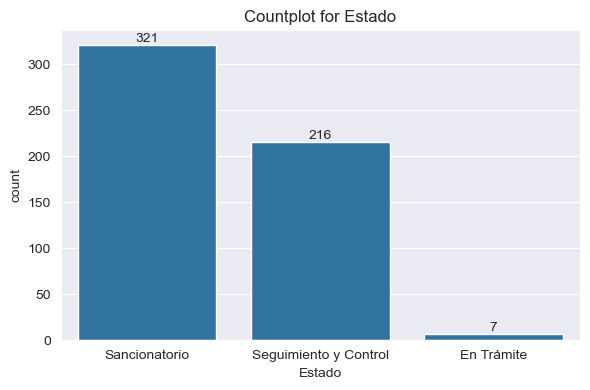

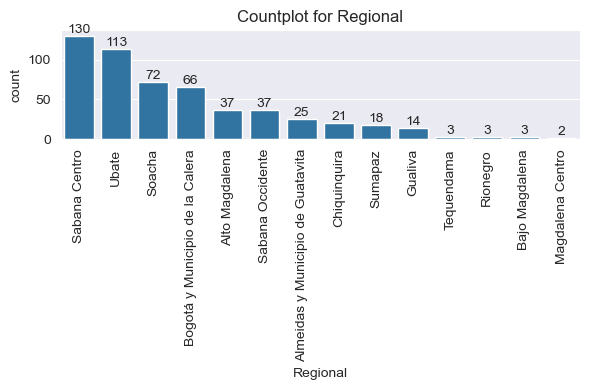

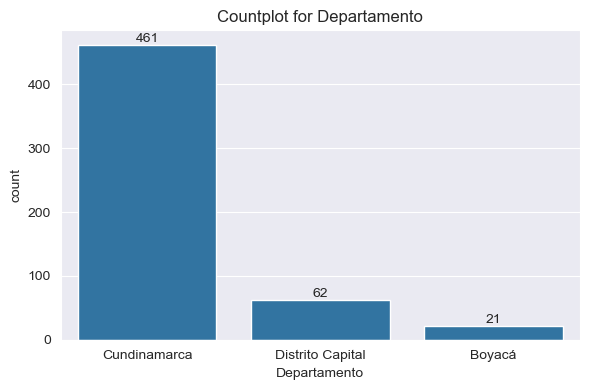

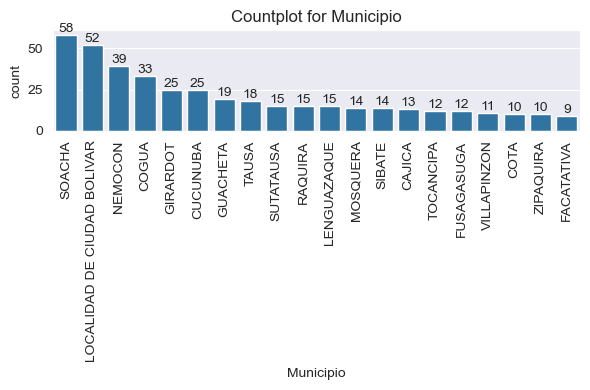

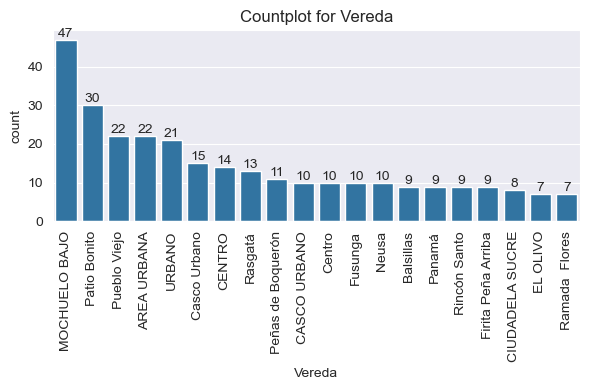

C:\Users\saras\AppData\Local\Temp\ipykernel_19660\4144202153.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


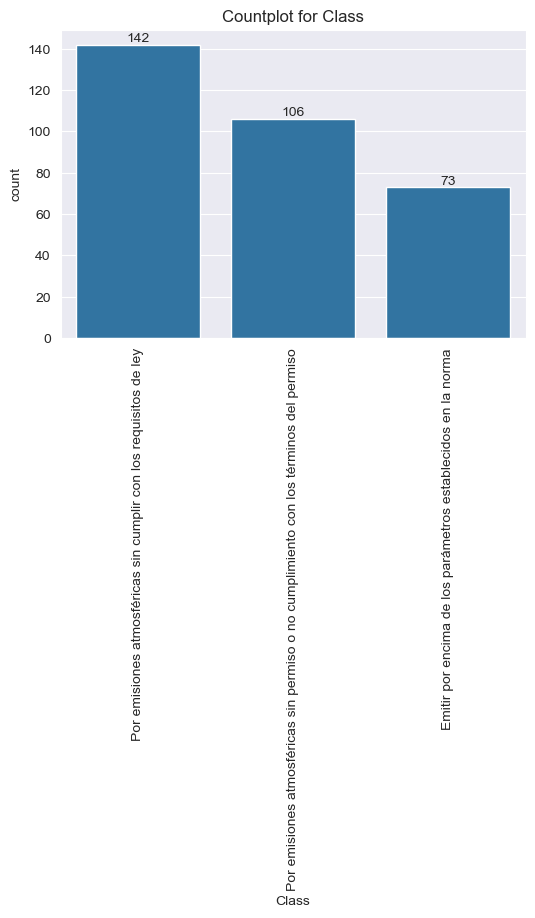

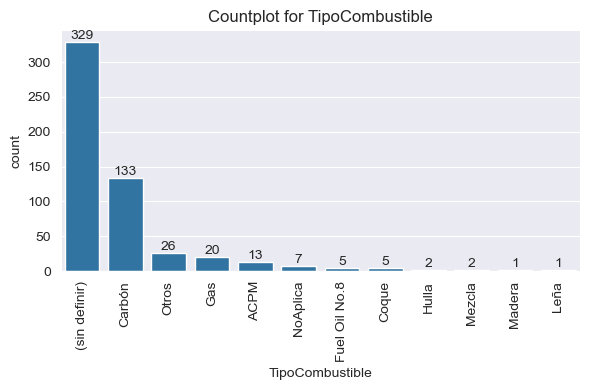

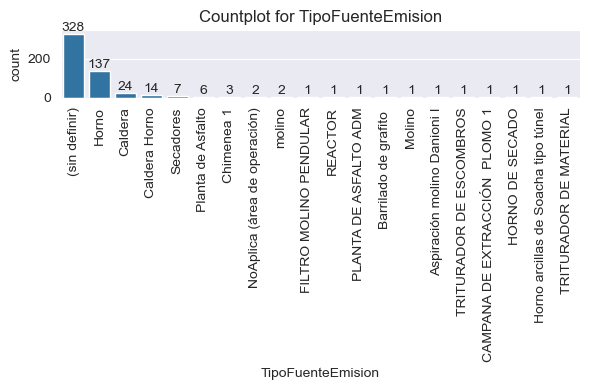

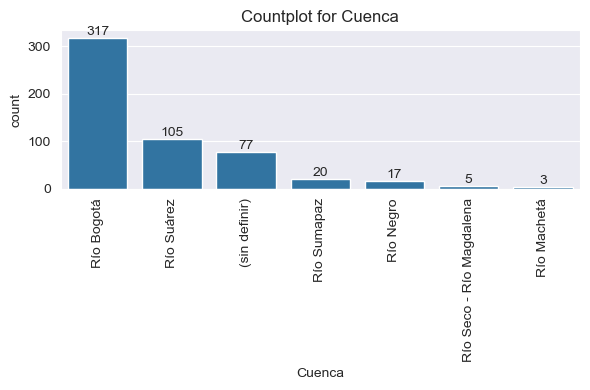

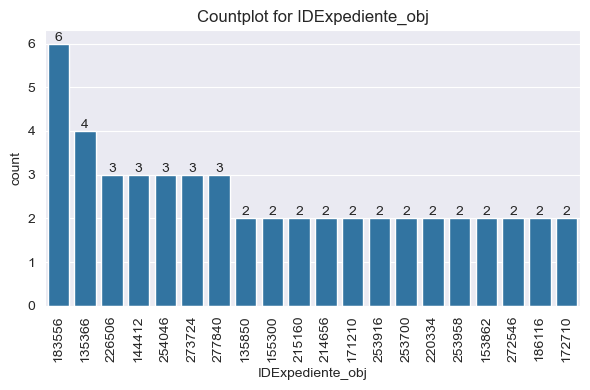

In [16]:
for col in non_numeric_attributes:
    # Tomar los 20 valores más frecuentes
    top_values = df[col].value_counts().head(20).index
    df_top = df[df[col].isin(top_values)]

    plt.figure(figsize=(6, 4))
    # Ordenar por la frecuencia en el countplot
    ax = sns.countplot(
        data=df_top, 
        x=col, 
        order=df_top[col].value_counts().index
    )

    if col in ['Regional', 'Municipio', 'Vereda', 'Class', 'TipoCombustible', 'TipoFuenteEmision', 'Cuenca', 'IDExpediente_obj']:
        for label in ax.get_xticklabels():
            label.set_rotation(90)
    
    # Mostrar los valores encima de las barras
    ax.bar_label(ax.containers[0])

    plt.title(f"Countplot for {col}")
    plt.tight_layout()
    plt.show()


**Hallazgos adicionales:**

- Hay varias palabras sin tildes, especialmente cuando se usan mayúsculas
- Hay inconsistencias en la escritura de nombres propios, especialmente por la capitalización y diferentes formas de referirse a un territorio

Se eliminan las variables creadas

In [17]:
df.drop(columns=['IDExpediente_obj'], inplace=True)

## 2. Variables numéricas

Variables numéricas encontradas

In [18]:
numeric_attributes = df.select_dtypes(include=['number']).columns.values
numeric_attributes = [col for col in numeric_attributes if col not in cols_otra_categoria]
pd.DataFrame(numeric_attributes, columns=['Numeric Attributes'])

,Numeric Attributes
0,Latitud
1,Longitud


Conteo de filas, promedio, desviación estándar, valores mínimo y máximo junto a los cuartiles

In [19]:
df[numeric_attributes].describe()

,Latitud,Longitud
count,544.000000,544.000000
mean,6.043605,-69.410725
std,4.253822,11.632202
min,3.887967,-74.818226
25%,4.653147,-74.191360
50%,5.066182,-73.952367
75%,5.317669,-73.785734
max,86.087159,-39.892151


**Hallazgos:**

- La latitud varía entre 3.88 y 86.09
- No obstante, no tienen sentido las latitudes superiores a 12.27, ya que allí se encuentra el punto más al norte de Colombia continental (Costa Atlántica) (Banco de la República, 2019)
- El 75% de las latitudes son iguales o menores a 5.32, lo cual tiene sentido dentro de los límites datos por la columna `Departamento`
- La longitud varía entre -74.81 y -39.90
- No obstante, no tienen sentido las longitudes superiores a -66.50, ya que allí se encuentra el punto más al este de Colombia (Región Amazónica) (Banco de la República, 2019)
- El 75% de las longitudes son iguales o menores a -73.79, lo cual tiene sentido dentro de los límites datos por la columna `Departamento`

Se pueden graficar las localizaciones geográficas, el área demarcada por las fuentes, junto a los límites superiores para la latitud y longitud 

**Nota:** Si presenta el error `Make this Notebook Trusted to load map: File -> Trust Notebook` y usa Anaconda, use la Anaconda Prompt para dirigirse a la carpeta `entendimiento` y escriba ```jupyter trust "Dataset 2 - Lugares de emisiones.ipynb"```

In [20]:
min_lat = df['Latitud'].min()
max_lat = df['Latitud'].max()
min_lon = df['Longitud'].min()
max_lon = df['Longitud'].max()

bounds = [
    [min_lat, min_lon],  # esquina inferior izquierda x
    [min_lat, max_lon],  # inferior derecha
    [max_lat, max_lon],  # superior derecha
    [max_lat, min_lon],  # superior izquierda
]

m = folium.Map(location=[4.71, -74.07], zoom_start=5)

# Dibujar el rectángulo
folium.Polygon(
    locations=bounds,
    color='blue',
    weight=2,
    fill=True,
    fill_opacity=0.1
).add_to(m)

# Agregar marcadores de cada ubicación del dataset
for _, row in df.iterrows():
    folium.Marker(
        location=[row['Latitud'], row['Longitud']],
        tooltip=f"{row['IDExpediente']} - Lat: {round(row['Latitud'], 2)}, Lon: {round(row['Longitud'], 2)}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Límites geográficos reales de Colombia
real_max_lat = 12.27
real_max_lon = -66.50

# Marcas adicionales para los límites geográficos de Colombia
folium.PolyLine(
    locations=[[real_max_lat, min_lon], [real_max_lat, real_max_lon]],
    color='green',
    weight=2,
    tooltip=f"Máxima latitud de Colombia terrestre: {real_max_lat}"
).add_to(m)

folium.PolyLine(
    locations=[[min_lat, real_max_lon], [real_max_lat, real_max_lon]],
    color='green',
    weight=2,
    tooltip=f"Mínima longitud de Colombia: {real_max_lon}"
).add_to(m)

m

**Hallazgos adicionales:**

- Hay un cúmulo de fuentes que están erróneamente ubicadas en el Océano Atlántico, entre Suramérica y África. Por ello, tienen problemas en su latitud y longitud
- Hay una fuente con identificador de expediente 110204 que está muy cerca del borde superior del mapa (latitud incorrecta) y su longitud se encuentra al nivel del departamento del Vichada, por lo que también es erróneo en ambas medidas

Visualización de esta información con diagramas de caja

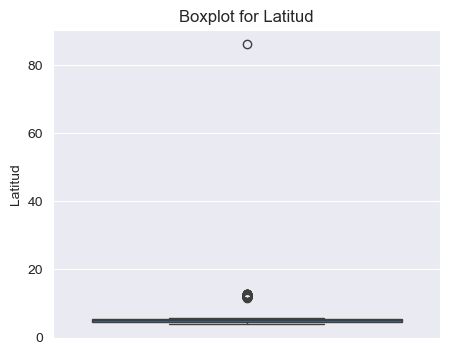

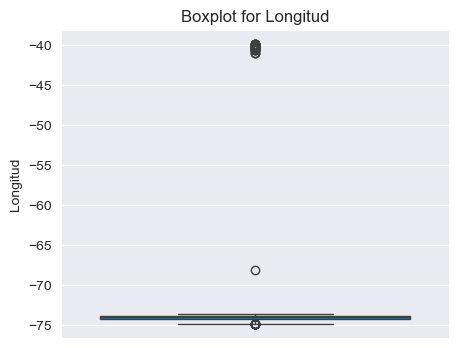

In [21]:
for col in numeric_attributes:
    plt.figure(figsize=(5,4))
    ax = sns.boxplot(data=df[col])
    ax.set_title(f"Boxplot for {col}")
    plt.xticks(rotation=45)
    plt.show()

**Hallazgos adicionales:** 

- Se evidencian los claros outliers superiores en latitud y longitud
- Los outliers inferiores de longitud tienen sentido, no deberían ser invalidados

Histogramas para visualizar la distribución de cada columna

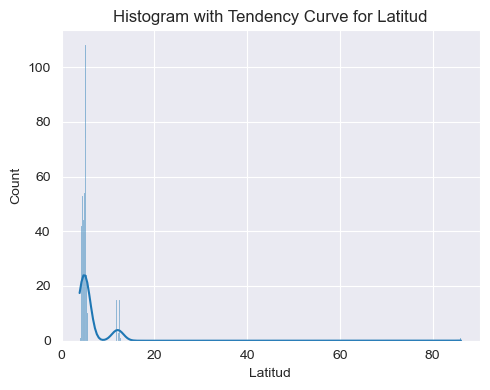

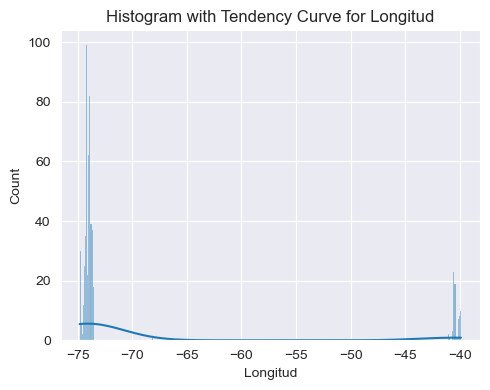

In [22]:
for col in df[numeric_attributes]:
    plt.figure(figsize=(5,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Histogram with Tendency Curve for {col}")
    plt.tight_layout()
    plt.show()

**Hallazgos adicionales:** 

- Hay una alta cantidad de fuentes en un rango (bin) de latitud válido
- Se evidencian los outliers

## 3. Calidad de datos

### 3.1. Completitud

**Resumen:** Hay nulos coherentes en una sola columna (`Class`), pero en las variables categóricas hay valores sin definir

**Valores de nulos por columna:** Se cuentan los nulos para todas las columnas

In [23]:
incompleteness_percentages =  (100 * df.isnull().sum() / df.shape[0]).sort_values(ascending=False)
pd.DataFrame({
    "Attribute": incompleteness_percentages.index,
    "Completeness (%)": 100 - incompleteness_percentages.values
})

,Attribute,Completeness (%)
0,Class,59.007353
1,IDExpediente,100.000000
2,Regional,100.000000
3,Estado,100.000000
4,Departamento,100.000000
5,Municipio,100.000000
6,Vereda,100.000000
7,TipoCombustible,100.000000
8,TipoFuenteEmision,100.000000
9,Cuenca,100.000000


**Hallazgos:**

- Todas las columnas están completas, a excepción de la columna `Class`
- Esto tiene sentido, ya que los nulos representan que no ha habido infracciones al permiso ambiental, relacionándose con el `Estado` no sancionatorio (en trámite o en seguimiento y control)
- Cerca de un 41% de las fuentes emisoras ha tenido alguna infracción, por lo que su estado es sancionatorio

In [24]:
df.groupby([df['Class'].fillna('(Vacío)'), 'Estado']).size().unstack(fill_value=0)

Estado,En Trámite,Sancionatorio,Seguimiento y Control
Class,,,
(Vacío),7,0,216
Emitir por encima de los parámetros establecidos en la norma,0,73,0
Por emisiones atmosféricas sin cumplir con los requisitos de ley,0,142,0
Por emisiones atmosféricas sin permiso o no cumplimiento con los términos del permiso,0,106,0


**Codificación para faltantes en las variables categóricas:** Gracias al perfilamiento de variables categóricas, se identifican los siguientes problemas de incompletitud más allá de los nulos. Ciertos problemas pueden presentarse en las mismas filas:

- En `TipoCombustible` hay valores de '(sin definir)'

In [25]:
df[(df['TipoCombustible'] == '(sin definir)')]

,IDExpediente,Estado,Regional,Departamento,Municipio,Vereda,Class,TipoCombustible,TipoFuenteEmision,Cuenca,Latitud,Longitud
42,138622,Seguimiento y Control,Sabana Centro,Cundinamarca,NEMOCON,Patio Bonito,None,(sin definir),(sin definir),Río Bogotá,5.118908,-73.895435
43,139320,Seguimiento y Control,Ubate,Cundinamarca,TAUSA,Rasgatá,None,(sin definir),Horno,Río Suárez,5.190613,-73.879585
61,150306,Seguimiento y Control,Sabana Centro,Cundinamarca,NEMOCON,Patio Bonito,None,(sin definir),(sin definir),Río Bogotá,5.125421,-73.904398
100,171196,Seguimiento y Control,Bogotá y Municipio de la Calera,Distrito Capital,LOCALIDAD DE CIUDAD BOLIVAR,MOCHUELO BAJO,None,(sin definir),(sin definir),Río Bogotá,4.506914,-74.150135
102,171204,Seguimiento y Control,Bogotá y Municipio de la Calera,Distrito Capital,LOCALIDAD DE CIUDAD BOLIVAR,MOCHUELO BAJO,None,(sin definir),(sin definir),Río Bogotá,4.516030,-74.149127
...,...,...,...,...,...,...,...,...,...,...,...,...
539,291446,Sancionatorio,Chiquinquira,Boyacá,RAQUIRA,CASCO URBANO,Por emisiones atmosféricas sin cumplir con los...,(sin definir),(sin definir),(sin definir),12.629099,-39.893628
540,291712,Sancionatorio,Sumapaz,Cundinamarca,ARBELAEZ,San Roque,Por emisiones atmosféricas sin cumplir con los...,(sin definir),(sin definir),Río Sumapaz,4.274013,-74.446186
541,292030,Sancionatorio,Ubate,Cundinamarca,CUCUNUBA,Pueblo Viejo,Por emisiones atmosféricas sin permiso o no cu...,(sin definir),(sin definir),Río Suárez,5.228254,-73.817856
542,292322,Sancionatorio,Alto Magdalena,Cundinamarca,GIRARDOT,URBANO,Emitir por encima de los parámetros establecid...,(sin definir),(sin definir),(sin definir),11.736503,-41.043145


- En `TipoFuenteEmision` hay valores de '(sin definir)'

In [26]:
df[(df['TipoFuenteEmision'] == '(sin definir)')]

,IDExpediente,Estado,Regional,Departamento,Municipio,Vereda,Class,TipoCombustible,TipoFuenteEmision,Cuenca,Latitud,Longitud
42,138622,Seguimiento y Control,Sabana Centro,Cundinamarca,NEMOCON,Patio Bonito,None,(sin definir),(sin definir),Río Bogotá,5.118908,-73.895435
61,150306,Seguimiento y Control,Sabana Centro,Cundinamarca,NEMOCON,Patio Bonito,None,(sin definir),(sin definir),Río Bogotá,5.125421,-73.904398
100,171196,Seguimiento y Control,Bogotá y Municipio de la Calera,Distrito Capital,LOCALIDAD DE CIUDAD BOLIVAR,MOCHUELO BAJO,None,(sin definir),(sin definir),Río Bogotá,4.506914,-74.150135
102,171204,Seguimiento y Control,Bogotá y Municipio de la Calera,Distrito Capital,LOCALIDAD DE CIUDAD BOLIVAR,MOCHUELO BAJO,None,(sin definir),(sin definir),Río Bogotá,4.516030,-74.149127
179,239650,Seguimiento y Control,Bogotá y Municipio de la Calera,Cundinamarca,LA CALERA,ALTAMAR,None,(sin definir),(sin definir),Río Bogotá,4.730325,-73.950578
...,...,...,...,...,...,...,...,...,...,...,...,...
539,291446,Sancionatorio,Chiquinquira,Boyacá,RAQUIRA,CASCO URBANO,Por emisiones atmosféricas sin cumplir con los...,(sin definir),(sin definir),(sin definir),12.629099,-39.893628
540,291712,Sancionatorio,Sumapaz,Cundinamarca,ARBELAEZ,San Roque,Por emisiones atmosféricas sin cumplir con los...,(sin definir),(sin definir),Río Sumapaz,4.274013,-74.446186
541,292030,Sancionatorio,Ubate,Cundinamarca,CUCUNUBA,Pueblo Viejo,Por emisiones atmosféricas sin permiso o no cu...,(sin definir),(sin definir),Río Suárez,5.228254,-73.817856
542,292322,Sancionatorio,Alto Magdalena,Cundinamarca,GIRARDOT,URBANO,Emitir por encima de los parámetros establecid...,(sin definir),(sin definir),(sin definir),11.736503,-41.043145


- En `Cuenca` hay valores de '(sin definir)'

In [27]:
df[(df['Cuenca'] == '(sin definir)')]

,IDExpediente,Estado,Regional,Departamento,Municipio,Vereda,Class,TipoCombustible,TipoFuenteEmision,Cuenca,Latitud,Longitud
19,124002,Seguimiento y Control,Soacha,Cundinamarca,SIBATE,Chacua,None,Otros,REACTOR,(sin definir),11.876446,-40.543104
35,136448,Seguimiento y Control,Soacha,Cundinamarca,SOACHA,AREA URBANA,None,Gas,Horno,(sin definir),11.886869,-40.527335
38,136886,Seguimiento y Control,Soacha,Cundinamarca,SIBATE,Chacua,None,NoAplica,FILTRO MOLINO PENDULAR,(sin definir),11.873642,-40.541236
40,137218,Seguimiento y Control,Soacha,Cundinamarca,SIBATE,Chacua,None,Carbón,Caldera,(sin definir),11.879025,-40.543524
44,139882,Seguimiento y Control,Soacha,Cundinamarca,SOACHA,Fusunga,None,Carbón,Horno,(sin definir),11.869339,-40.501231
...,...,...,...,...,...,...,...,...,...,...,...,...
536,289234,Sancionatorio,Chiquinquira,Boyacá,RAQUIRA,RESGUARDO OCCIDENTE,Por emisiones atmosféricas sin permiso o no cu...,(sin definir),(sin definir),(sin definir),12.627894,-39.913430
537,289754,Sancionatorio,Gualiva,Cundinamarca,VILLETA,CASCO URBANO,Por emisiones atmosféricas sin cumplir con los...,(sin definir),(sin definir),(sin definir),12.287815,-40.673199
539,291446,Sancionatorio,Chiquinquira,Boyacá,RAQUIRA,CASCO URBANO,Por emisiones atmosféricas sin cumplir con los...,(sin definir),(sin definir),(sin definir),12.629099,-39.893628
542,292322,Sancionatorio,Alto Magdalena,Cundinamarca,GIRARDOT,URBANO,Emitir por encima de los parámetros establecid...,(sin definir),(sin definir),(sin definir),11.736503,-41.043145


### 3.2. Unicidad

**Resumen:** Un 1.47% de las filas son duplicados completos

Cantidad de filas duplicadas

In [28]:
total_duplicate_rows = df.duplicated().sum()
duplicate_rows_percentage = 100.0 * total_duplicate_rows / df.shape[0]
print(f"{total_duplicate_rows} duplicate rows ({duplicate_rows_percentage:.2f}%)")

8 duplicate rows (1.47%)


Filas duplicadas (incluyendo la primera aparición)

In [29]:
df[df.duplicated(keep=False)]

,IDExpediente,Estado,Regional,Departamento,Municipio,Vereda,Class,TipoCombustible,TipoFuenteEmision,Cuenca,Latitud,Longitud
30,135366,Seguimiento y Control,Almeidas y Municipio de Guatavita,Cundinamarca,SUESCA,CHITIVA ABAJO,None,Carbón,Horno,Río Bogotá,5.099271,-73.805679
31,135366,Seguimiento y Control,Almeidas y Municipio de Guatavita,Cundinamarca,SUESCA,CHITIVA ABAJO,None,Carbón,Horno,Río Bogotá,5.099271,-73.805679
53,144412,Seguimiento y Control,Ubate,Cundinamarca,GUACHETA,Rabanal,None,Carbón,Horno,Río Suárez,5.336710,-73.704902
54,144412,Seguimiento y Control,Ubate,Cundinamarca,GUACHETA,Rabanal,None,Carbón,Horno,Río Suárez,5.336710,-73.704902
161,220334,Seguimiento y Control,Ubate,Cundinamarca,LENGUAZAQUE,Ramada Flores,None,Carbón,Horno,Río Suárez,5.324353,-73.711387
162,220334,Seguimiento y Control,Ubate,Cundinamarca,LENGUAZAQUE,Ramada Flores,None,Carbón,Horno,Río Suárez,5.324353,-73.711387
166,226506,Seguimiento y Control,Soacha,Cundinamarca,SOACHA,Fusunga,None,Carbón,Horno,Río Bogotá,4.549327,-74.207452
167,226506,Seguimiento y Control,Soacha,Cundinamarca,SOACHA,Fusunga,None,Carbón,Horno,Río Bogotá,4.549327,-74.207452
168,226506,Seguimiento y Control,Soacha,Cundinamarca,SOACHA,Fusunga,None,Carbón,Horno,Río Bogotá,4.549327,-74.207452
199,253958,Seguimiento y Control,Ubate,Cundinamarca,CUCUNUBA,Pueblo Viejo,None,Hulla,Horno,(sin definir),12.399668,-40.077358


**Hallazgos:**

- Un 1.47% de las filas son duplicadas completas
- Aparecen entre 2 y 3 veces en el dataset
- Este comportamiento no tiene sentido, y arruina las tareas de visualización

Cantidad de filas duplicadas sin considerar columna relacionada con identificación `IDExpediente`

In [30]:
df_without_id = df.drop(columns=['IDExpediente'])
total_duplicate_rows = df_without_id.duplicated().sum()
duplicate_rows_percentage = 100.0 * total_duplicate_rows / df.shape[0]
print(f"{total_duplicate_rows} duplicate rows ({duplicate_rows_percentage:.2f}%)")

14 duplicate rows (2.57%)


Filas duplicadas (incluyendo la primera aparición)

In [31]:
df_without_id[df_without_id.duplicated(keep=False)]

,Estado,Regional,Departamento,Municipio,Vereda,Class,TipoCombustible,TipoFuenteEmision,Cuenca,Latitud,Longitud
30,Seguimiento y Control,Almeidas y Municipio de Guatavita,Cundinamarca,SUESCA,CHITIVA ABAJO,None,Carbón,Horno,Río Bogotá,5.099271,-73.805679
31,Seguimiento y Control,Almeidas y Municipio de Guatavita,Cundinamarca,SUESCA,CHITIVA ABAJO,None,Carbón,Horno,Río Bogotá,5.099271,-73.805679
53,Seguimiento y Control,Ubate,Cundinamarca,GUACHETA,Rabanal,None,Carbón,Horno,Río Suárez,5.336710,-73.704902
54,Seguimiento y Control,Ubate,Cundinamarca,GUACHETA,Rabanal,None,Carbón,Horno,Río Suárez,5.336710,-73.704902
161,Seguimiento y Control,Ubate,Cundinamarca,LENGUAZAQUE,Ramada Flores,None,Carbón,Horno,Río Suárez,5.324353,-73.711387
162,Seguimiento y Control,Ubate,Cundinamarca,LENGUAZAQUE,Ramada Flores,None,Carbón,Horno,Río Suárez,5.324353,-73.711387
166,Seguimiento y Control,Soacha,Cundinamarca,SOACHA,Fusunga,None,Carbón,Horno,Río Bogotá,4.549327,-74.207452
167,Seguimiento y Control,Soacha,Cundinamarca,SOACHA,Fusunga,None,Carbón,Horno,Río Bogotá,4.549327,-74.207452
168,Seguimiento y Control,Soacha,Cundinamarca,SOACHA,Fusunga,None,Carbón,Horno,Río Bogotá,4.549327,-74.207452
199,Seguimiento y Control,Ubate,Cundinamarca,CUCUNUBA,Pueblo Viejo,None,Hulla,Horno,(sin definir),12.399668,-40.077358


**Hallazgos:**

- Un 2.57% de las filas son duplicadas al considerar todos los atributos excepto el `IDExpediente`
- Aparecen entre 2 y 3 veces en el dataset
- Este comportamiento sí tiene sentido, ya que las coordenadas idénticas sugieren que estas fuentes están verticalmente superpuestas, como chimeneas en diferentes pisos de un mismo edificio o equipos instalados a distintas alturas en una estructura vertical.
- Se hace dicho supuesto ya que una ubicación geográfica con 6 decimales es bastante precisa (11 cms de incertidumbre)

Cantidad de valores duplicados por cada columna

In [32]:
duplicate_counts = []
duplicate_percentages = []

for col in df.columns:
    duplicates = df.shape[0] - df[col].nunique()
    duplicate_counts.append(duplicates)
    duplicate_percentages.append((duplicates / df.shape[0]) * 100)

duplicates_df = pd.DataFrame({
    "Column": df.columns,
    "Duplicate Count": duplicate_counts,
    "Duplicate Percentage": duplicate_percentages
}).sort_values(by="Duplicate Count", ascending=False).reset_index(drop=True)

duplicates_df

,Column,Duplicate Count,Duplicate Percentage
0,Estado,541,99.448529
1,Departamento,541,99.448529
2,Class,541,99.448529
3,Cuenca,537,98.713235
4,TipoCombustible,532,97.794118
5,Regional,530,97.426471
6,TipoFuenteEmision,514,94.485294
7,Municipio,479,88.051471
8,Vereda,396,72.794118
9,IDExpediente,42,7.720588


**Hallazgos:** Los demás duplicados por columna tienen sentido

### 3.3. Consistencia

**Resumen:** 

**Consistencia semántica:** Si bien en la columna `Departamento` está en valor único de Distrito Capital, sigue teniendo sentido, ya que Bogotá es tratada en algunas ocasiones de forma diferente a Cundinamarca al ser un distrito especial. Sin embargo, se podría pasar todos estos valores a 'Cundinamarca' para mantener coherencia.

Otro problema similar es que la columna `Municipio` incluye localidades de Bogotá, con el prefijo 'LOCALIDAD DE '. Sin embargo, no se necesitan acciones concretas.

**Consistencia de la presentación de variables categóricas:** Gracias al perfilamiento de variables categóricas, podemos evidenciar que algunas variables están escritas de forma inconsistente: algunas totalmente en mayúsculas, otras en minúsculas, otras con mayúscula inicial, entre otras variaciones. 

A continuación, se evidencian todos los tipos de capitalización en las variables mencionadas:

In [33]:
def detect_casing(text: str) -> str:
    # extrae palabras con acentos y eñes
    words = re.findall(r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+", str(text))
    if not words:
        return "Other"

    # todas en mayúsculas
    if all(w.isupper() for w in words):
        return "UPPERCASE"

    # todas en minúsculas
    if all(w.islower() for w in words):
        return "lowercase"

    # todas Capitalized (primera letra mayúscula y resto minúsculas)
    if all(w[0].isupper() and w[1:].islower() for w in words):
        return "Capitalized"

    return "Other"


def casing_summary_df(df: pd.DataFrame) -> pd.DataFrame:
    text_columns = df.select_dtypes(include=["object", "string"]).columns
    results = {}
    other_examples = {}

    for col in text_columns:
        # Detect casing per value (sin dropna para mantener índices alineados)
        casing_series = df[col].apply(detect_casing)

        # Calculate percentages (acá sí se puede descartar nulos)
        casing_counts = casing_series.value_counts()
        casing_percent = (casing_counts / casing_counts.sum() * 100).round(2)
        results[col] = casing_percent

        # Capture up to 5 examples that fall into "Other"
        mask_other = casing_series == "Other"
        other_vals = df.loc[mask_other, col].dropna().unique()[:5]

        if len(other_vals) > 0:
            other_examples[col] = ", ".join(map(str, other_vals))
        else:
            other_examples[col] = "(Sin ejemplos)"

    # Build summary dataframe
    summary_df = pd.DataFrame(results).T.fillna(0)

    # Add the column with examples of 'Other'
    summary_df["Ejemplos Other"] = summary_df.index.map(lambda col: other_examples[col])

    return summary_df

print("Porcentajes de diferentes tipos de capitalización en variables categóricas:")
casing_summary_df(df)

Porcentajes de diferentes tipos de capitalización en variables categóricas:


,Capitalized,Other,UPPERCASE,lowercase,Ejemplos Other
Estado,60.29,39.71,0.00,0.00,Seguimiento y Control
Regional,83.27,16.73,0.00,0.00,"Almeidas y Municipio de Guatavita, Bogotá y Mu..."
Departamento,100.00,0.00,0.00,0.00,(Sin ejemplos)
Municipio,0.00,0.00,100.00,0.00,(Sin ejemplos)
Vereda,60.48,5.51,34.01,0.00,"La isla, Peñas de Boquerón, Peñas de Cajón, Ce..."
Class,40.99,59.01,0.00,0.00,Por emisiones atmosféricas sin cumplir con los...
TipoCombustible,35.85,1.29,2.39,60.48,NoAplica
TipoFuenteEmision,34.38,2.57,2.21,60.85,"Planta de Asfalto, NoAplica (área de operación..."
Cuenca,85.85,0.00,0.00,14.15,(Sin ejemplos)


**Hallazgos:**

- En `Vereda` hay valores capitalizados, completamente en mayúsculas y mixtos. Se recomienda estandarizar a solo mayúsculas
- En `TipoFuenteEmision` hay de todos los formatos. Se recomienda estandarizar a solo mayúsculas
- En `TipoCombustible` y `Cuenca` hay valores diferentes a lo usual (en minúsculas), pero esto se debe a los valores sin definir, por lo que no hay anomalías adicionales que deban ser tratadas

**Otros problemas de consistencia y presentación:** En la etapa de perfilamiento, se identificaron estos problemas en valores únicos.

- En `Municipio` hay un valor único 'LOC.USAQUEN CERROS ORIENTALES', que en realidad hace referencia a 'LOCALIDAD DE USAQUEN'

In [34]:
df[df['Municipio'] == 'LOC.USAQUEN CERROS ORIENTALES']

,IDExpediente,Estado,Regional,Departamento,Municipio,Vereda,Class,TipoCombustible,TipoFuenteEmision,Cuenca,Latitud,Longitud
498,272438,Sancionatorio,Bogotá y Municipio de la Calera,Distrito Capital,LOC.USAQUEN CERROS ORIENTALES,EL PÁRAMO,Por emisiones atmosféricas sin cumplir con los...,(sin definir),(sin definir),(sin definir),11.954859,-40.324566


- Por presentación, se pueden mapear los 'NoAplica' en `TipoCombustible` a 'No aplica'

In [35]:
df[df['TipoCombustible'] == 'NoAplica']

,IDExpediente,Estado,Regional,Departamento,Municipio,Vereda,Class,TipoCombustible,TipoFuenteEmision,Cuenca,Latitud,Longitud
11,102214,Seguimiento y Control,Sabana Centro,Cundinamarca,TENJO,La Punta,None,NoAplica,NoAplica (área de operación),Río Bogotá,4.781656,-74.186743
38,136886,Seguimiento y Control,Soacha,Cundinamarca,SIBATE,Chacua,None,NoAplica,FILTRO MOLINO PENDULAR,(sin definir),11.873642,-40.541236
182,246026,Seguimiento y Control,Sabana Occidente,Cundinamarca,MOSQUERA,San José,None,NoAplica,molino buhler,Río Bogotá,4.696015,-74.208578
185,249462,Seguimiento y Control,Ubate,Cundinamarca,CUCUNUBA,Aposentos,None,NoAplica,Horno,Río Suárez,5.227280,-73.781441
187,251256,Seguimiento y Control,Sabana Centro,Cundinamarca,TOCANCIPA,Canavita,None,NoAplica,Horno,Río Bogotá,4.948368,-73.938482
211,269526,Seguimiento y Control,Sabana Centro,Cundinamarca,TOCANCIPA,Verganzo,None,NoAplica,Caldera,Río Bogotá,4.963031,-73.959777
220,277246,Seguimiento y Control,Ubate,Cundinamarca,LENGUAZAQUE,La Ramada,None,NoAplica,NoAplica (área de operación),Río Suárez,5.320792,-73.715413


- Por consistencia de idioma, se pueden mapear los 'Fuel Oil No.8' en `TipoCombustible` a 'Fueloil No. 8'. No es estrictamente necesario.

In [36]:
df[df['TipoCombustible'] == 'Fuel Oil No.8']

,IDExpediente,Estado,Regional,Departamento,Municipio,Vereda,Class,TipoCombustible,TipoFuenteEmision,Cuenca,Latitud,Longitud
3,75972,Seguimiento y Control,Sabana Occidente,Cundinamarca,MOSQUERA,Balsillas,None,Fuel Oil No.8,Planta de Asfalto,Río Bogotá,4.678797,-74.284112
10,93120,Seguimiento y Control,Sabana Occidente,Cundinamarca,MOSQUERA,Balsillas,None,Fuel Oil No.8,Planta de Asfalto,Río Bogotá,4.685590,-74.276291
14,117700,Seguimiento y Control,Sabana Occidente,Cundinamarca,MOSQUERA,Balsillas,None,Fuel Oil No.8,PLANTA DE ASFALTO ADM,Río Bogotá,4.677816,-74.267952
83,166542,Seguimiento y Control,Soacha,Cundinamarca,SIBATE,La Unión,None,Fuel Oil No.8,Horno,(sin definir),11.868159,-40.553758
143,203658,Seguimiento y Control,Sabana Centro,Cundinamarca,CAJICA,Chuntame Bajo,None,Fuel Oil No.8,PLANTA DE MEZCLA ASFÁLTICA,Río Bogotá,4.950794,-74.014653


- Por presentación, se pueden mapear los 'NoAplica (área de operación)' en `TipoFuenteEmision` a 'No aplica (área de operación)'

In [37]:
df[df['TipoFuenteEmision'] == 'NoAplica (área de operación)']

,IDExpediente,Estado,Regional,Departamento,Municipio,Vereda,Class,TipoCombustible,TipoFuenteEmision,Cuenca,Latitud,Longitud
11,102214,Seguimiento y Control,Sabana Centro,Cundinamarca,TENJO,La Punta,None,NoAplica,NoAplica (área de operación),Río Bogotá,4.781656,-74.186743
220,277246,Seguimiento y Control,Ubate,Cundinamarca,LENGUAZAQUE,La Ramada,None,NoAplica,NoAplica (área de operación),Río Suárez,5.320792,-73.715413


**Consistencia a través de agrupaciones de características:** Se pueden explorar diferentes agrupaciones en búsqueda de inconsistencias

- **Inconsistencia entre variables categóricas geográficas:** Si bien en la mayoría de agrupaciones parece no haber problemas, podría existir uno con el municipio de Sibaté y la supuesta vereda Chusacá, que es en realidad otro municipio. Tal vez es una confusión con la vereda Chacua. 

In [38]:
print_table(df.groupby(['Departamento', 'Municipio', 'Vereda', 'Cuenca']).size().reset_index(name='Counts'))

┌─────┬──────────────────┬───────────────────────────────┬────────────────────────┬──────────────────────────┬──────────┐
│     │ Departamento     │ Municipio                     │ Vereda                 │ Cuenca                   │   Counts │
├─────┼──────────────────┼───────────────────────────────┼────────────────────────┼──────────────────────────┼──────────┤
│   0 │ Boyacá           │ CHIQUINQUIRA                  │ CASCO URBANO           │ (sin definir)            │        1 │
│   1 │ Boyacá           │ CHIQUINQUIRA                  │ CASCO URBANO           │ Río Suárez               │        3 │
│   2 │ Boyacá           │ CHIQUINQUIRA                  │ Sucre Oriental         │ Río Suárez               │        2 │
│   3 │ Boyacá           │ RAQUIRA                       │ CASCO URBANO           │ (sin definir)            │        1 │
│   4 │ Boyacá           │ RAQUIRA                       │ Firita Peña Arriba     │ (sin definir)            │        3 │
│   5 │ Boyacá          

- **Consistencia entre tipos:** Se agrupa por tipo de combustible y tipo de fuente, sin evidenciar relaciones anómalas

In [39]:
print_table(df.groupby(['TipoCombustible', 'TipoFuenteEmision']).size().reset_index(name="Count"))

┌────┬───────────────────┬─────────────────────────────────────┬─────────┐
│    │ TipoCombustible   │ TipoFuenteEmision                   │   Count │
├────┼───────────────────┼─────────────────────────────────────┼─────────┤
│  0 │ (sin definir)     │ (sin definir)                       │     328 │
│  1 │ (sin definir)     │ Horno                               │       1 │
│  2 │ ACPM              │ Caldera                             │       4 │
│  3 │ ACPM              │ Caldera Horno                       │       1 │
│  4 │ ACPM              │ Horno                               │       1 │
│  5 │ ACPM              │ PLANTA TRITURADORA                  │       1 │
│  6 │ ACPM              │ Planta de Asfalto                   │       3 │
│  7 │ ACPM              │ Secadores                           │       3 │
│  8 │ Carbón            │ 700 BHP VR2                         │       1 │
│  9 │ Carbón            │ Batería de coquización A            │       1 │
│ 10 │ Carbón            

### 3.4. Validez

**Resumen:** Un 13,97% de los datos tiene una ubicación geográfica inválida

**Rangos y outliers:** Como se pudo ver en el perfilamiento de variables numéricas, hay problemas en el rango y los outliers de las siguientes columnas. Para tener más detalles, veamos cuántos datos son inválidos por su ubicación.

- Las fuentes con latitudes mayores a 12.27 o longitudes mayores a -66.50 son inválidas

In [43]:
df_mal_ubicacion = df[(df['Latitud'] >= 12.27) | (df['Longitud'] >= -66.50)]
print(f"Fuentes con mala ubicación: {len(df_mal_ubicacion)} ({(len(df_mal_ubicacion)/len(df))*100:.2f}%)")
df_mal_ubicacion

Fuentes con mala ubicación: 76 (13.97%)


,IDExpediente,Estado,Regional,Departamento,Municipio,Vereda,Class,TipoCombustible,TipoFuenteEmision,Cuenca,Latitud,Longitud
19,124002,Seguimiento y Control,Soacha,Cundinamarca,SIBATE,Chacua,None,Otros,REACTOR,(sin definir),11.876446,-40.543104
35,136448,Seguimiento y Control,Soacha,Cundinamarca,SOACHA,AREA URBANA,None,Gas,Horno,(sin definir),11.886869,-40.527335
38,136886,Seguimiento y Control,Soacha,Cundinamarca,SIBATE,Chacua,None,NoAplica,FILTRO MOLINO PENDULAR,(sin definir),11.873642,-40.541236
40,137218,Seguimiento y Control,Soacha,Cundinamarca,SIBATE,Chacua,None,Carbón,Caldera,(sin definir),11.879025,-40.543524
44,139882,Seguimiento y Control,Soacha,Cundinamarca,SOACHA,Fusunga,None,Carbón,Horno,(sin definir),11.869339,-40.501231
...,...,...,...,...,...,...,...,...,...,...,...,...
536,289234,Sancionatorio,Chiquinquira,Boyacá,RAQUIRA,RESGUARDO OCCIDENTE,Por emisiones atmosféricas sin permiso o no cu...,(sin definir),(sin definir),(sin definir),12.627894,-39.913430
537,289754,Sancionatorio,Gualiva,Cundinamarca,VILLETA,CASCO URBANO,Por emisiones atmosféricas sin cumplir con los...,(sin definir),(sin definir),(sin definir),12.287815,-40.673199
539,291446,Sancionatorio,Chiquinquira,Boyacá,RAQUIRA,CASCO URBANO,Por emisiones atmosféricas sin cumplir con los...,(sin definir),(sin definir),(sin definir),12.629099,-39.893628
542,292322,Sancionatorio,Alto Magdalena,Cundinamarca,GIRARDOT,URBANO,Emitir por encima de los parámetros establecid...,(sin definir),(sin definir),(sin definir),11.736503,-41.043145


## 4.  Análisis adicionales

Se puede efectuar un Pandas Profiling para encontrar más información

En especial, son de gran interés las correlaciones y las interacciones entre variables

El informe puede encontrarse en `archivos_generados/Reporte perfilamiento - Dataset 2 Original.html`

In [45]:
reporte = ProfileReport(df)
reporte.to_file("archivos_generados/Reporte perfilamiento - Dataset 2 Original.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 112.45it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**Hallazgos:**

Valores faltantes y duplicados:

- Un 3,4% de las celdas están vacías (233)
- Un 1,3% de las filas están duplicadas (7)

Características de las variables:

- Por tipo de dato, hay 3 variables numéricas, 7 categóricas y 2 de texto
- `Departamento`, `TipoCombustible` y `TipoFuenteEmision` están altamente imbalanceadas

Correlaciones:

- `Class` está altamente correlacionada con `Estado` (1.0), `TipoCombustible` (1.0) y `TipoFuenteEmision` (1.0)
- `Cuenca` está altamente correlacionada con `Longitud` (0.695) y `Regional` (0.686)
- `Departamento` está altamente correlacionado con `Regional` (0.972)
- `Estado` está altamente correlacionado con `Class` (1.0), `TipoCombustible` (0.676) y `TipoFuenteEmision` (0.657)
- `Latitud` está altamente correlacionada con `Longitud` (0.907)
- `Longitud` está altamente correlacionada con `Latitud` (0.907) y `Cuenca` (0.695)
- `Regional` está altamente correlacionada con `Cuenca` (0.686) y `Departamento` (0.972)
- `TipoCombustible` está altamente correlacionado con `Class` (1.0) y `Estado` (0.676)
- `TipoFuenteEmision` está altamente correlacionado con `Class` (1.0) y `Estado` (0.657)

# 5. Referencias

Banco de la República. (30 de septiembre de 2019). Posición astronómica y geográfica de Colombia. _Enciclopedia Banrepcultural_. https://enciclopedia.banrepcultural.org/index.php?title=Posici%C3%B3n_astron%C3%B3mica_y_geogr%C3%A1fica_de_Colombia